# Plot model predictions for sector width in range expansions experiments

In [79]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from community import community
matplotlib.rc("figure", figsize=(10,5))
sns.set_theme(style="white", palette="deep")
sns.set_palette("deep")

from scipy.stats import t

## Load Data

In [80]:
#load dictionary with fit parameters from file
with open('Processed-datafiles/fit_parameters.txt', 'r') as file:
    fit_pars = eval(file.read())

#load dictionary with growth rates from file    
with open('Experimental-datafiles/growth_rates.txt', 'r') as file:
    growth_rates = eval(file.read())
    
#we replace WT growth rate with average growth rate of dP and dT in presence of AA, as this is our actual control condition
growth_rates['WT'] = (growth_rates['dP'] + growth_rates['dT'])/2   
    
#load dataframe with preprocessing results
df_in = pd.read_csv('Processed-datafiles/community_data_mean.csv')  
  
#select data eq. values
df_data = pd.DataFrame({"community": df_in["Condition"],
                        'Sector Width $\Delta$proC': df_in["dP_patch"], 
                        'Sector Width $\Delta$proC SE': df_in["dP_patch_std"] / np.sqrt(df_in['N_eq']), # add standard error
                        'Sector Width $\Delta$trpC': df_in["dT_patch"], 
                        'Sector Width $\Delta$trpC SE': df_in["dT_patch_std"] / np.sqrt(df_in['N_eq']), # add standard error
                        "source": "Data"})

#drop AA condition
df_data = df_data[df_data['community'] != 'AA'].reset_index(drop=True)

#rename community names to match paper
community_names = { 'A' : 'Ctr',
                    'B' : 'Pu',    #Pu: increased uptake of P
                    'C' : 'Tp',    #Tp: increased production of T
                    'D' : 'Tp Pu',  #Tp Pu: increased production of T and uptake of P
                    'E' : 'Pp',    #Pp: increased production of P
                    'F' : 'Pp Pu',  #Pp Pu: increased production of P and uptake of P
                    'G' : 'Tp Pp',  #Tp Pp: increased production of T and P
                    'H' : 'Tp Pp Pu' #Tp Pp Pu: increased production of T and P and uptake of P
                    }
df_data['community'] = df_data['community'].replace(community_names)
df_data.head(n=8)

,community,Sector Width $\Delta$proC,Sector Width $\Delta$proC SE,Sector Width $\Delta$trpC,Sector Width $\Delta$trpC SE,source
0,Ctr,52.947683,6.266087,11.290686,0.832991,Data
1,Pu,10.536059,2.546922,9.237860,0.431384,Data
2,Tp,18.913275,4.904147,8.585891,0.789854,Data
3,Tp Pu,5.035559,0.019638,22.793291,4.680639,Data
4,Pp,227.426170,4.514031,117.138821,9.418133,Data
5,Pp Pu,176.149557,24.365054,120.195380,3.662633,Data
6,Tp Pp,116.726639,8.578284,105.564071,6.689470,Data
7,Tp Pp Pu,136.856448,4.289513,112.732017,0.856771,Data


---

## Predict community properties

As we do not know the precise increase in Proline uptake rate, we thus estimate Eq. frequencies assuming a 10, 50, or 100-fold increase.

In [81]:
df_list = [df_data]

#loop over the different values of proline uptake fold increase
Pu_fold_increase = np.array([10, 50, 100])

for pu in Pu_fold_increase:
    
    #specify the parameters for the different communities
    par_com_A = { #Ctr: original community
                'ndim': 3,
                'lPro': fit_pars['lPro'], 
                'lTrp': fit_pars['lTrp'], 
                'c_prod_T': 1, 
                'c_prod_P': 1,
                'c_up_P': 1,
                'mu_WT': growth_rates['WT'],
                'mu_dP': growth_rates['dP'],
                'mu_dT': growth_rates['dT'],
                }

    par_com_B = { #Pu: increased uptake of P
                'ndim': 3,
                'lPro': fit_pars['lPro'], 
                'lTrp': fit_pars['lTrp'], 
                'c_prod_T': 1, 
                'c_prod_P': 1,
                'c_up_P': pu,
                'mu_WT': growth_rates['WT'],
                'mu_dP': growth_rates['dP_proUp'],
                'mu_dT': growth_rates['dT'],
                }

    par_com_C = { #Tp: increased production of T
                'ndim': 3,
                'lPro': fit_pars['lPro'], 
                'lTrp': fit_pars['lTrp'], 
                'c_prod_T': fit_pars['c_prod_T'], 
                'c_prod_P': 1,
                'c_up_P': 1,
                'mu_WT': growth_rates['WT'],
                'mu_dP': growth_rates['dP_trpOP'],
                'mu_dT': growth_rates['dT'],
                }

    par_com_D = { # Tp Pu: increased production of T and uptake of P
                'ndim': 3,
                'lPro': fit_pars['lPro'], 
                'lTrp': fit_pars['lTrp'], 
                'c_prod_T': fit_pars['c_prod_T'], 
                'c_prod_P': 1,
                'c_up_P': pu,
                'mu_WT': growth_rates['WT'],
                'mu_dP': growth_rates['dP_proUp_trpOP'],
                'mu_dT': growth_rates['dT'],
                }

    par_com_E = { #Pp: increased production of P
                'ndim': 3,
                'lPro': fit_pars['lPro'], 
                'lTrp': fit_pars['lTrp'], 
                'c_prod_T': 1, 
                'c_prod_P': fit_pars['c_prod_P'],
                'c_up_P': 1,
                'mu_WT': growth_rates['WT'],
                'mu_dP': growth_rates['dP'],
                'mu_dT': growth_rates['dT_proOP'],
                }

    par_com_F = { #Pp Pu: increased production of P and uptake of P
                'ndim': 3,
                'lPro': fit_pars['lPro'], 
                'lTrp': fit_pars['lTrp'], 
                'c_prod_T': 1, 
                'c_prod_P': fit_pars['c_prod_P'],
                'c_up_P': pu,
                'mu_WT': growth_rates['WT'],
                'mu_dP': growth_rates['dP_proUp'], 
                'mu_dT': growth_rates['dT_proOP'],
                }


    par_com_G = { #Tp Pp: increased production of T and P
                'ndim': 3,
                'lPro': fit_pars['lPro'], 
                'lTrp': fit_pars['lTrp'], 
                'c_prod_T': fit_pars['c_prod_T'], 
                'c_prod_P': fit_pars['c_prod_P'],
                'c_up_P': 1,
                'mu_WT': growth_rates['WT'],
                'mu_dP': growth_rates['dP_trpOP'],
                'mu_dT': growth_rates['dT_proOP'],
                }

    par_com_H = { #Tp Pp Pu: increased production of T and P and uptake of P
                'ndim': 3,
                'lPro': fit_pars['lPro'], 
                'lTrp': fit_pars['lTrp'], 
                'c_prod_T': fit_pars['c_prod_T'], 
                'c_prod_P': fit_pars['c_prod_P'],
                'c_up_P': pu,
                'mu_WT': growth_rates['WT'],
                'mu_dP': growth_rates['dP_proUp_trpOP'], 
                'mu_dT': growth_rates['dT_proOP'],
                }

    #create a dictionary with the parameters for the different communities
    par_coms = {'Ctr': par_com_A, #Ctr: original community
                'Pu': par_com_B, #Pu: increased uptake of P
                'Tp': par_com_C, #Tp: increased production of T
                'Tp Pu': par_com_D, #Tp Pu: increased production of T and uptake of P
                'Pp': par_com_E, #Pp: increased production of P
                'Pp Pu': par_com_F, #Pp Pu: increased production of P and uptake of P
                'Tp Pp': par_com_G, #Tp Pp: increased production of T and P
                'Tp Pp Pu': par_com_H} #Tp Pp Pu: increased production of T and P and uptake of P   

    #run the community model for the different communities
    communities = {key: community(**val) for key, val in par_coms.items()}

    #extract the equilibrium properties of the different communities
    df_pred = pd.DataFrame({"community": df_data["community"],
                            "source": f"Model {pu}-fold increase Pro uptake"}) 
    for key, val in communities.items():
        df_pred.loc[df_pred["community"]==key, "Sector Width $\Delta$proC"] = val.rangeP
        df_pred.loc[df_pred["community"]==key, "Sector Width $\Delta$trpC"] = val.rangeT


    df_list.append(df_pred)

df = pd.concat(df_list, ignore_index=True)
df.to_csv('Processed-datafiles/predictions_sectorwidth.csv', index=False)

In [82]:
# Calculate the change in frequency for the different communities relative to the control

control_set =  { # define the set of communities to calculate normalized range, key is the focal community, value is the control community
    'Pu' : "Ctr",
    'Tp Pu' : "Tp",
    'Pp Pu' : "Pp",
    'Tp Pp Pu' : "Tp Pp"}

norm_data = []

for source in df['source'].unique():
    df_loc = df[df['source'] == source]
    
    for key, val in control_set.items():
        
        focal_dP = df_loc[df_loc['community'] == key]['Sector Width $\Delta$proC'].values[0]
        ctrl_dP = df_loc[df_loc['community'] == val]['Sector Width $\Delta$proC'].values[0]
        focal_dT = df_loc[df_loc['community'] == key]['Sector Width $\Delta$trpC'].values[0]
        ctrl_dT = df_loc[df_loc['community'] == val]['Sector Width $\Delta$trpC'].values[0]
        
        focal_dP_SE = df_loc[df_loc['community'] == key]['Sector Width $\Delta$proC SE'].values[0]
        ctrl_dP_SE = df_loc[df_loc['community'] == val]['Sector Width $\Delta$proC SE'].values[0]   
        focal_dT_SE = df_loc[df_loc['community'] == key]['Sector Width $\Delta$trpC SE'].values[0]
        ctrl_dT_SE = df_loc[df_loc['community'] == val]['Sector Width $\Delta$trpC SE'].values[0]
        
        norm_sec_dP = focal_dP / ctrl_dP
        norm_sec_dT = focal_dT / ctrl_dT
        
        # norm_sec = sec_focal / sec_control -> norm_sec_SE = sqrt(sec_control**2 * SE_focal**2 + sec_focal**2 * SE_control**2) / sec_control**2
        norm_sec_dP_SE = np.sqrt(ctrl_dP**2 * focal_dP_SE**2 + focal_dP**2 * ctrl_dP_SE**2) / ctrl_dP**2
        norm_sec_dT_SE = np.sqrt(ctrl_dT**2 * focal_dT_SE**2 + focal_dT**2 * ctrl_dT_SE**2) / ctrl_dT**2
        
        norm_data.append({"community": f"{key} vs {val}", "source": source, "Normalized Sector Width $\Delta$proC": norm_sec_dP, "Normalized Sector Width $\Delta$proC SE": norm_sec_dP_SE,"Normalized Sector Width $\Delta$trpC": norm_sec_dT, "Normalized Sector Width $\Delta$trpC SE": norm_sec_dT_SE}) 
        
    
df_norm = pd.DataFrame(norm_data)

## Plot comparison of model predictions and data

### Plot predictions sector width frequency

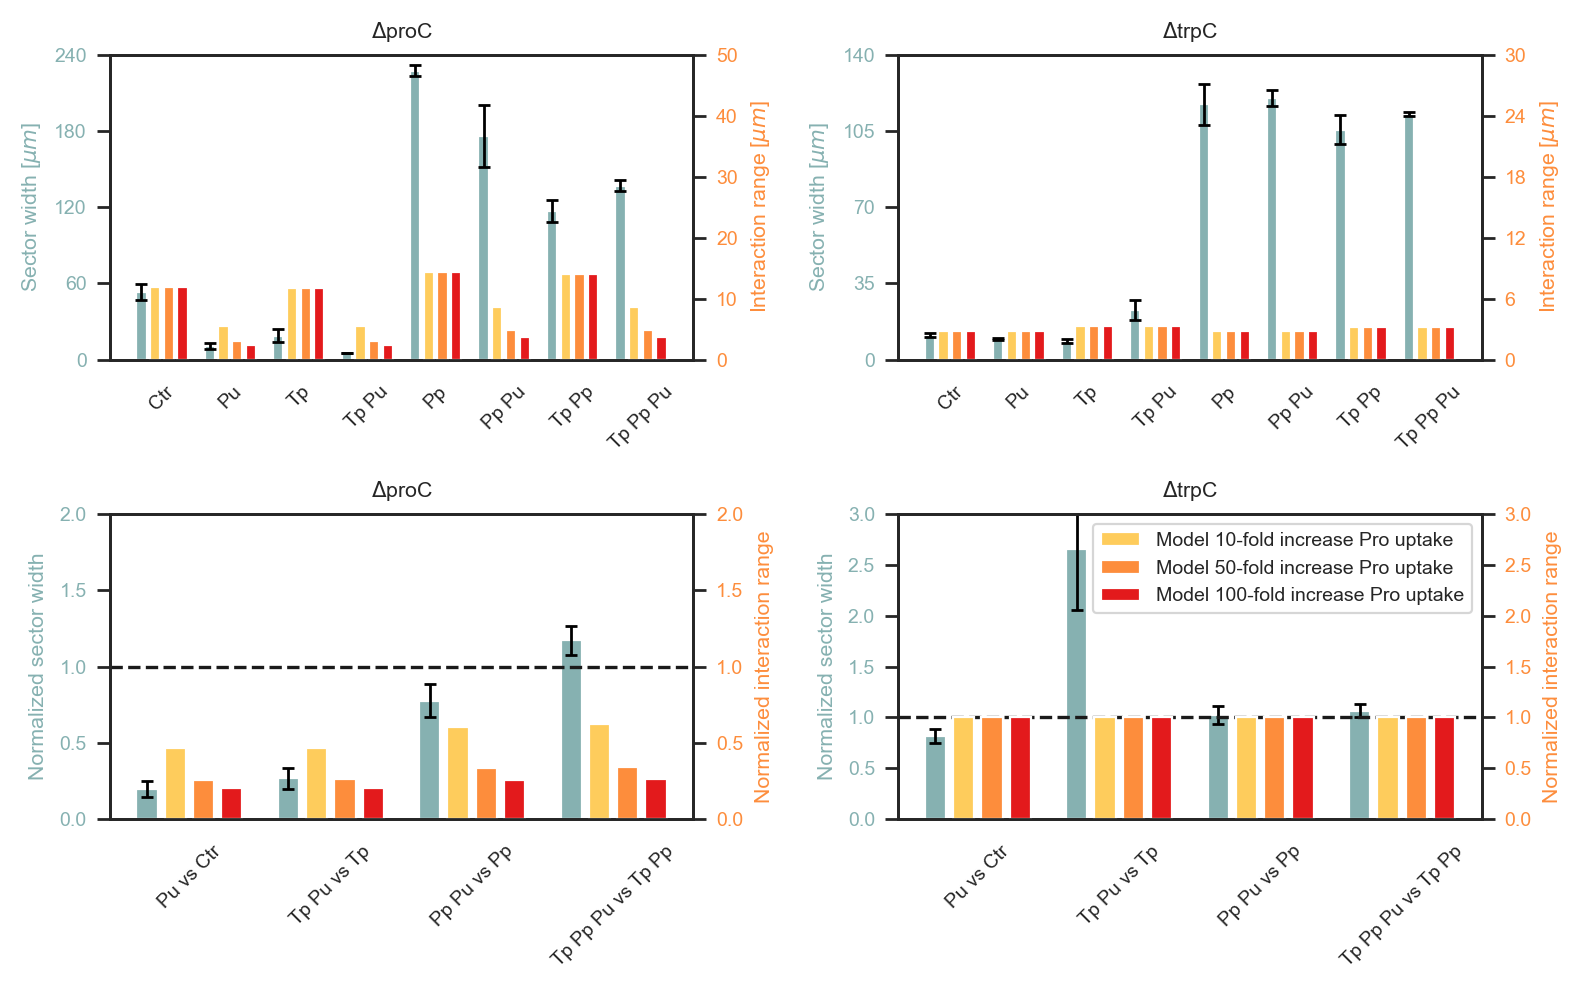

In [90]:
# Apply seaborn style
sns.set_theme(style="white", palette="deep")
sns.set_palette("deep")

# Set the context with smaller font scale
sns.set_context("paper", font_scale=0.8)

# colors for the different sources
col = np.array([
    [134, 177, 177],
    [254,204,92],
    [253,141,60],
    [227,26,28]
]) / 255

#plot the prediction and data for EQ freq and relative range
fig, axs = plt.subplots(2,2,figsize=(8,5))

#absolute values proC
hues = df["source"].unique()
xvals = df["community"].unique()
x = np.arange(len(xvals))  # the label locations
width = (1 - 0.1*len(hues))/len(hues)   # the width of the bars
offset_vec = np.linspace(-1,1,len(hues))*0.3

ax1 = axs[0][0]
ax2 = ax1.twinx()
for idx, hue in enumerate(hues):
    y = df[df["source"] == hue]["Sector Width $\Delta$proC"].to_numpy()
    err = df[df["source"] == hue]["Sector Width $\Delta$proC SE"].to_numpy()
    if idx==0:
        ax1.bar(x + offset_vec[idx], y, width, label=hue, yerr=err, error_kw=dict(ecolor='black', lw=1, capsize=2, capthick=1), color=col[idx,:])
    else:
        ax2.bar(x + offset_vec[idx], y, width, label=hue, yerr=err, error_kw=dict(ecolor='black', lw=1, capsize=2, capthick=1), color=col[idx,:])


maxy = 240
ax1.set_ylim(0,maxy)
ax1.set_yticks(np.linspace(0, maxy, 5))
ax1.set_ylabel('Sector width [$\mu m$]', color=col[0,:])
ax1.tick_params(axis='y', labelcolor=col[0,:])

maxy = 50
ax2.set_ylim(0,maxy)
ax2.set_yticks(np.linspace(0, maxy, 6))
ax2.set_ylabel('Interaction range [$\mu m$]', color=col[2,:])
ax2.tick_params(axis='y', labelcolor=col[2,:])
#ax2.legend(loc='upper right')
ax2.set_title('$\Delta$proC')
ax2.set_xticks(x)
ax2.set_xticklabels(xvals)
ax1.tick_params(axis='x', rotation=45)
fig.tight_layout()


#absolute values trpC
ax1 = axs[0][1]
ax2 = ax1.twinx()
for idx, hue in enumerate(hues):
    y = df[df["source"] == hue]["Sector Width $\Delta$trpC"].to_numpy()
    err = df[df["source"] == hue]["Sector Width $\Delta$trpC SE"].to_numpy()
    if idx==0:
        ax1.bar(x + offset_vec[idx], y, width, label=hue, yerr=err, error_kw=dict(ecolor='black', lw=1, capsize=2, capthick=1), color=col[idx,:])
    else:
        ax2.bar(x + offset_vec[idx], y, width, label=hue, yerr=err, error_kw=dict(ecolor='black', lw=1, capsize=2, capthick=1), color=col[idx,:])


maxy = 140
ax1.set_ylim(0,maxy)
ax1.set_yticks(np.linspace(0, maxy, 5))
ax1.set_ylabel('Sector width [$\mu m$]', color=col[0,:])
ax1.tick_params(axis='y', labelcolor=col[0,:])

maxy = 30
ax2.set_ylim(0,maxy)
ax2.set_yticks(np.linspace(0, maxy, 6))
ax2.set_ylabel('Interaction range [$\mu m$]', color=col[2,:])
ax2.tick_params(axis='y', labelcolor=col[2,:])
#ax2.legend(loc='upper right')
ax2.set_title('$\Delta$trpC')
ax2.set_xticks(x)
ax2.set_xticklabels(xvals)
ax1.tick_params(axis='x', rotation=45)
fig.tight_layout()


## Plot normalized data
hues = df_norm["source"].unique()
xvals = df_norm["community"].unique()
x = np.arange(len(xvals))  # the label locations
width = (1 - 0.1*len(hues))/len(hues)   # the width of the bars
offset_vec = np.linspace(-1,1,len(hues))*0.3

#normalized values proC
ax1 = axs[1][0]
ax2 = ax1.twinx()
for idx, hue in enumerate(hues):
    y = df_norm[df_norm["source"] == hue]["Normalized Sector Width $\Delta$proC"].to_numpy()
    err = df_norm[df_norm["source"] == hue]["Normalized Sector Width $\Delta$proC SE"].to_numpy()
    if idx==0:
        ax1.bar(x + offset_vec[idx], y, width, label=hue, yerr=err, error_kw=dict(ecolor='black', lw=1, capsize=2, capthick=1), color=col[idx,:])
    else:
        ax2.bar(x + offset_vec[idx], y, width, label=hue, yerr=err, error_kw=dict(ecolor='black', lw=1, capsize=2, capthick=1), color=col[idx,:])


ax1.set_ylim(0,2)
ax1.set_yticks(np.linspace(0, 2, 5))
ax1.set_ylabel('Normalized sector width', color=col[0,:])
ax1.tick_params(axis='y', labelcolor=col[0,:])

ax2.set_ylim(0,2)
ax2.set_yticks(np.linspace(0, 2, 5))
ax2.set_ylabel('Normalized interaction range', color=col[2,:])
ax2.tick_params(axis='y', labelcolor=col[2,:])
#ax2.legend(loc='upper right')
ax2.set_title('$\Delta$proC')
ax2.set_xticks(x)
ax2.set_xticklabels(xvals)
ax1.tick_params(axis='x', rotation=45)
ax1.axhline(y=1, color='k', linestyle='--')
fig.tight_layout()

#normalized values trpC
ax1 = axs[1][1]
ax2 = ax1.twinx()
for idx, hue in enumerate(hues):
    y = df_norm[df_norm["source"] == hue]["Normalized Sector Width $\Delta$trpC"].to_numpy()
    err = df_norm[df_norm["source"] == hue]["Normalized Sector Width $\Delta$trpC SE"].to_numpy()
    if idx==0:
        ax1.bar(x + offset_vec[idx], y, width, label=hue, yerr=err, error_kw=dict(ecolor='black', lw=1, capsize=2, capthick=1), color=col[idx,:])
    else:
        ax2.bar(x + offset_vec[idx], y, width, label=hue, yerr=err, error_kw=dict(ecolor='black', lw=1, capsize=2, capthick=1), color=col[idx,:])


ax1.set_ylim(0,3)
ax1.set_ylabel('Normalized sector width', color=col[0,:])
ax1.tick_params(axis='y', labelcolor=col[0,:])

ax2.set_ylim(0,3)
ax2.set_ylabel('Normalized interaction range', color=col[2,:])
ax2.tick_params(axis='y', labelcolor=col[2,:])
ax2.legend(loc='upper right')
ax2.set_title('$\Delta$trpC')
ax2.set_xticks(x)
ax1.tick_params(axis='x', rotation=45)
ax2.set_xticklabels(xvals)
ax1.axhline(y=1, color='k', linestyle='--')
fig.tight_layout()


fig.savefig(f"Figures/model_predictions_sector_width.pdf")
plt.show()

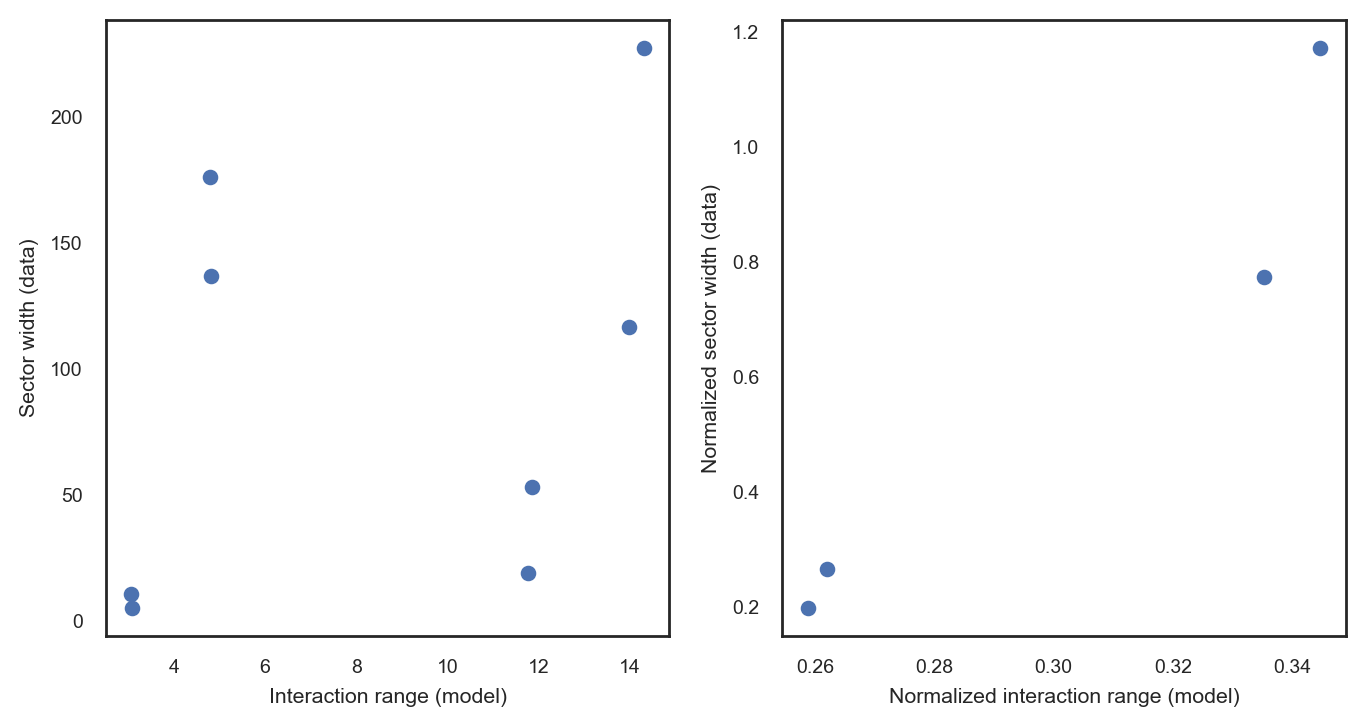

In [102]:
fig, axs = plt.subplots(1,2,figsize=(8,4))

axs[0].scatter(y=df[df['source'] == 'Data']["Sector Width $\Delta$proC"], x=df[df['source'] == 'Model 50-fold increase Pro uptake']["Sector Width $\Delta$proC"])
axs[0].set_xlabel('Interaction range (model)')
axs[0].set_ylabel('Sector width (data)')

axs[1].scatter(y=df_norm[df_norm['source'] == 'Data']["Normalized Sector Width $\Delta$proC"], x=df_norm[df_norm['source'] == 'Model 50-fold increase Pro uptake']["Normalized Sector Width $\Delta$proC"])
axs[1].set_xlabel('Normalized interaction range (model)')
axs[1].set_ylabel('Normalized sector width (data)')
plt.show()
